In [ ]:
#!pip install scikit-learn


In [ ]:
#!pip install recordlinkage

In [ ]:
#!pip install ydata_profiling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import confusion_matrix
import seaborn as sns

from ydata_profiling import ProfileReport

import recordlinkage
import itertools

In [21]:
# Read dataset
data = pd.read_csv('Comune-di-Milano-Strutture-ricettive-alberghiere.csv',sep=';',encoding='unicode_escape')
data.head()

,Ubicazione,Tipo via,Descrizione via,Civico,Codice via,ZD,Camere,Camere piano,Categoria,Insegna,Piani totali,Piano piano,Posti letto,Posti letto per piano,Tipo attività struture extra
0,ALZ NAVIGLIO GRANDE N. 8 (z.d. 6),ALZ,NAVIGLIO GRANDE,8.0,5144.0,6.0,14.0,NaN,4,HOTEL MAISON BORELLA,NaN,NaN,25.0,NaN,Albergo
1,codvia 0000 num.024 ; (),NaN,NaN,NaN,NaN,NaN,259.0,259,4,radisson blu hotel milan,NaN,NaN,518.0,518,Albergo
2,CSO BUENOS AIRES N. 18 (z.d. 3),CSO,BUENOS AIRES,18.0,2129.0,3.0,16.0,16,1,hotel aurora,1.0,1,25.0,25,Albergo
3,CSO BUENOS AIRES N. 26 (z.d. 3),CSO,BUENOS AIRES,26.0,2129.0,3.0,25.0,NaN,3,hotel buenos aires,NaN,NaN,39.0,NaN,Albergo
4,CSO BUENOS AIRES N. 2 (z.d. 3),CSO,BUENOS AIRES,2.0,2129.0,3.0,46.0,15;11;8,3,albergo fenice,4.0,1;2;3;4,98.0,24;19;13,Albergo


# Data profiling

* Data exploration

In [22]:
#Data type
data.dtypes

Ubicazione                       object
Tipo via                         object
Descrizione via                  object
Civico                          float64
Codice via                      float64
ZD                              float64
Camere                          float64
Camere piano                     object
Categoria                        object
Insegna                          object
Piani totali                    float64
Piano piano                      object
Posti letto                     float64
Posti letto per piano            object
Tipo attività struture extra     object
dtype: object

In [23]:
# Shows if duplicates exist
data.duplicated().any()

False

In [24]:
# Number of null values for each column
data.isnull().sum()

Ubicazione                        0
Tipo via                         14
Descrizione via                  14
Civico                           30
Codice via                       14
ZD                               14
Camere                            1
Camere piano                    106
Categoria                         7
Insegna                          10
Piani totali                    264
Piano piano                     252
Posti letto                       1
Posti letto per piano           106
Tipo attività struture extra     10
dtype: int64

Completeness: 

In [25]:
# To evaluate completeness:

#total number of not null values
NOT_NULL = data.count().sum()
#total number of null values
NULL = data.isnull().sum().sum()
#total number of cells
TOT = NOT_NULL + NULL
TOT   #ok (451*15 -> 6765)

COMPLETENESS = '{:,.2%}'.format(NOT_NULL/TOT)
print("Completeness:", COMPLETENESS)
print("Total null values:", NULL)

Completeness: 87.54%
Total null values: 843


In [26]:
# ADDITIONAL CHECK: dealing with missing values with a different format:
MISSING = ['--', 'na', 'n.a.', 'N/A', 'NA', 'NaN', 'nan', 'null', 'Null', 'NULL'] #just to test

PROPERTY = pd.read_csv('./Comune-di-Milano-Strutture-ricettive-alberghiere.csv', sep=';',encoding='unicode_escape', na_values = MISSING)
PROPERTY
print(PROPERTY.isnull().sum().sum()) #<- result same as before

843


Consistency:

In [27]:
STRUTTURE_COPY = data.copy()
STRUTTURE_COPY.head()

#rules definition:
#       - 1)Camere = sum Camere piano
#       - 2)Piani totali = sum Piano piano
#       - 3)Posti letto = sum Posti letto per piano
#       - 4)Camere <= (minor/equal) Posti letto

sum_Camere = STRUTTURE_COPY['Camere piano'].apply(lambda x: sum(int(n) for n in str(x).split(';') if n.strip().isdigit()))
STRUTTURE_COPY['Check_sum_camere'] = np.where(STRUTTURE_COPY['Camere'] == sum_Camere, 1, 0)

sum_Piano = STRUTTURE_COPY['Piano piano'].apply(lambda x: len([n for n in str(x).split(';') if n.strip() != '' and pd.notna(n)]))
STRUTTURE_COPY['Check_sum_piani'] = np.where(STRUTTURE_COPY['Piani totali'] == sum_Piano, 1, 0)

sum_Posti_letto_piano = STRUTTURE_COPY['Posti letto per piano'].apply(lambda x: sum(int(n) for n in str(x).split(';') if n.strip().isdigit()))
STRUTTURE_COPY['Check_sum_posti_letto'] = np.where(STRUTTURE_COPY['Posti letto'] == sum_Posti_letto_piano, 1, 0)

STRUTTURE_COPY['Check_camere_minore_letti'] = np.where(STRUTTURE_COPY['Camere'] <= STRUTTURE_COPY['Posti letto'], 1, 0)

STRUTTURE_COPY.head()

,Ubicazione,Tipo via,Descrizione via,Civico,Codice via,ZD,Camere,Camere piano,Categoria,Insegna,Piani totali,Piano piano,Posti letto,Posti letto per piano,Tipo attività struture extra,Check_sum_camere,Check_sum_piani,Check_sum_posti_letto,Check_camere_minore_letti
0,ALZ NAVIGLIO GRANDE N. 8 (z.d. 6),ALZ,NAVIGLIO GRANDE,8.0,5144.0,6.0,14.0,NaN,4,HOTEL MAISON BORELLA,NaN,NaN,25.0,NaN,Albergo,0,0,0,1
1,codvia 0000 num.024 ; (),NaN,NaN,NaN,NaN,NaN,259.0,259,4,radisson blu hotel milan,NaN,NaN,518.0,518,Albergo,1,0,1,1
2,CSO BUENOS AIRES N. 18 (z.d. 3),CSO,BUENOS AIRES,18.0,2129.0,3.0,16.0,16,1,hotel aurora,1.0,1,25.0,25,Albergo,1,1,1,1
3,CSO BUENOS AIRES N. 26 (z.d. 3),CSO,BUENOS AIRES,26.0,2129.0,3.0,25.0,NaN,3,hotel buenos aires,NaN,NaN,39.0,NaN,Albergo,0,0,0,1
4,CSO BUENOS AIRES N. 2 (z.d. 3),CSO,BUENOS AIRES,2.0,2129.0,3.0,46.0,15;11;8,3,albergo fenice,4.0,1;2;3;4,98.0,24;19;13,Albergo,0,1,0,1


In [28]:
check_1_not_null=STRUTTURE_COPY[STRUTTURE_COPY['Camere'].notna()& 
                                STRUTTURE_COPY['Camere piano'].notna()]
check_2_not_null=STRUTTURE_COPY[STRUTTURE_COPY['Piani totali'].notna()& 
                                STRUTTURE_COPY['Piano piano'].notna()]
check_3_not_null=STRUTTURE_COPY[STRUTTURE_COPY['Posti letto per piano'].notna()& 
                                STRUTTURE_COPY['Posti letto'].notna()]
check_4_not_null=STRUTTURE_COPY[STRUTTURE_COPY['Camere'].notna()& 
                                STRUTTURE_COPY['Posti letto'].notna()]

In [29]:
#count the number of consistent tuples considering the rule
CONSISTENT1 = sum(check_1_not_null['Check_sum_camere'] == 1)
CONSISTENT2 = sum(check_2_not_null['Check_sum_piani'] == 1)
CONSISTENT3 = sum(check_3_not_null['Check_sum_posti_letto'] == 1)
CONSISTENT4 = sum(check_4_not_null['Check_camere_minore_letti'] == 1)

CONSISTENCY1 = '{:,.2%}'.format((CONSISTENT1 / check_1_not_null['Check_sum_camere'].count()))
CONSISTENCY2 = '{:,.2%}'.format((CONSISTENT2 / check_2_not_null['Check_sum_piani'].count()))
CONSISTENCY3 = '{:,.2%}'.format((CONSISTENT3 / check_3_not_null['Check_sum_posti_letto'].count()))
CONSISTENCY4 = '{:,.2%}'.format((CONSISTENT4 / check_4_not_null['Check_camere_minore_letti'].count()))

print("Consistency Check 1 (Camere = somma Camere piano): ", CONSISTENCY1)
print("Consistency Check 2 (Piani totali = somma Piano piano): ", CONSISTENCY2)
print("Consistency Check 3 (Posti letto = somma Posti letto per piano): ", CONSISTENCY3)
print("Consistency Check 4 (Camere <= Posti letto): ", CONSISTENCY4)

Consistency Check 1 (Camere = somma Camere piano):  31.30%
Consistency Check 2 (Piani totali = somma Piano piano):  94.64%
Consistency Check 3 (Posti letto = somma Posti letto per piano):  26.38%
Consistency Check 4 (Camere <= Posti letto):  100.00%


* Data quality assessment

In [ ]:
# Generate report
profile = ProfileReport(data, title="Pandas Profiling Report")
profile

# Save profile into html file
profile.to_file("STRUTTURE_Report.html")

# Data cleaning

## Formatting and normalization

In [30]:
#Change column names
data=data.rename(columns={"Descrizione via":"Nome via", "ZD":"Municipio", "Camere":"Camere tot", 
                          "Camere piano":"Camere per piano", "Categoria":"Numero stelle", "Insegna":"Nome",
                          "Piano piano": "Elenco piani", "Posti letto":"Posti letto tot",
                          "Tipo attività struture extra":"Tipologia"})

In [31]:
# Make all strings uppercase
data["Nome"] = data["Nome"].str.upper()
data["Nome via"] = data["Nome via"].str.upper()
data["Ubicazione"] = data["Ubicazione"].str.upper()
data["Tipo via"] = data["Tipo via"].str.upper()
print(data["Tipologia"].unique())
data["Tipologia"] = data["Tipologia"].str.upper() #Tipologia goes from three categories to two just by changing to uppercase
print(data["Tipologia"].unique())

['Albergo' 'Residence' nan 'albergo']
['ALBERGO' 'RESIDENCE' nan]


In [32]:
print(data["Numero stelle"].unique())
data.loc[data['Numero stelle'] == '5 STELLE LUSSO', 'Numero stelle'] = '6'
data.loc[data['Numero stelle'] == 'I', 'Numero stelle'] = np.nan
data.loc[data['Numero stelle'] == 'l', 'Numero stelle'] = np.nan
data["Numero stelle"] = data["Numero stelle"].astype("Int64")
data["Numero stelle"].unique()

['4' '1' '3' '5' nan 'l' '2' 'I' '5 STELLE LUSSO']


<IntegerArray>
[4, 1, 3, 5, <NA>, 2, 6]
Length: 7, dtype: Int64

In [33]:
# Posti letto per piano and Camere per piano have a lot of null values and are inconsistent with Camere tot and Posti letto tot, so we can drop the column
data = data.drop(["Posti letto per piano"], axis = 1)
data = data.drop(["Camere per piano"], axis = 1)

In [34]:
data[data["Elenco piani"].notna()]

,Ubicazione,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Numero stelle,Nome,Piani totali,Elenco piani,Posti letto tot,Tipologia
2,CSO BUENOS AIRES N. 18 (Z.D. 3),CSO,BUENOS AIRES,18.0,2129.0,3.0,16.0,1,HOTEL AURORA,1.0,1,25.0,ALBERGO
4,CSO BUENOS AIRES N. 2 (Z.D. 3),CSO,BUENOS AIRES,2.0,2129.0,3.0,46.0,3,ALBERGO FENICE,4.0,1;2;3;4,98.0,ALBERGO
6,CSO BUENOS AIRES N. 3 (Z.D. 3),CSO,BUENOS AIRES,3.0,2129.0,3.0,116.0,4,CRISTOFORO COLOMBO,4.0,2;3;4;5,191.0,ALBERGO
12,CSO EUROPA N. 9 (Z.D. 1),CSO,EUROPA,9.0,300.0,1.0,89.0,4,HOTEL GALILEO,7.0,1;2;3;4;5;6;7,159.0,ALBERGO
14,CSO GARIBALDI GIUSEPPE N. 84 (Z.D. 1),CSO,GARIBALDI GIUSEPPE,84.0,1010.0,1.0,98.0,4,CARLYLE BRERA HOTEL,7.0,1;2;3;4;5;6;7,203.0,ALBERGO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,VLE SUZZANI GIOVANNI NUM.013/15 ; (Z.D. 9),NaN,NaN,NaN,NaN,NaN,131.0,3,HOTEL IBIS MILANO CA GRANDA,4.0,1;2;3;4,262.0,ALBERGO
444,VLE TESTI FULVIO N. 300 (Z.D. 9),VLE,TESTI FULVIO,300.0,1441.0,9.0,140.0,4,STARHOTELS TOURIST,NaN,R;1;2;3;4;5,250.0,ALBERGO
446,VLE TUNISIA N. 6 (Z.D. 3),VLE,TUNISIA,6.0,2121.0,3.0,13.0,1,HOTEL KENNEDY,1.0,6,23.0,ALBERGO
447,VLE TUNISIA N. 9 (Z.D. 3),VLE,TUNISIA,9.0,2121.0,3.0,50.0,4,ST. GEORGE HOTEL,NaN,A;1;2;3;4,99.0,ALBERGO


In [35]:
#Elenco piani instead is consistent with Piani totali and can be used to fill some of the Nan in piani totali and then it can be dropped, since it's data are non structured 
count_piani_elenco = data['Elenco piani'].str.split(';').str.len()
data = data.drop(["Elenco piani"], axis = 1)
print("NaN in Piani totali",data['Piani totali'].isna().sum())
data['Piani totali'] = data['Piani totali'].fillna(count_piani_elenco)
data['Piani totali'] = data['Piani totali'].astype("Int64")
print("NaN in Piani totali after filling",data['Piani totali'].isna().sum())

NaN in Piani totali 264
NaN in Piani totali after filling 233


Ubicazione doesn't contain null values, so it can be used to fill some of the missing values of columns "Tipo Via", "Nome via", "Civico", "Municipio". 
After being used, this column can be dropped since all the important data are present in other, more structured, columns

In [36]:
Split_tipologia=data.Ubicazione.str.split(' ',n=1,expand=True)
data[['Tipo via 2','Ubi2']]=Split_tipologia
data = data.drop(["Ubicazione"], axis = 1)
data[data["Tipo via"]!=data["Tipo via 2"]] #Check that the old Tipo via is coherent
#Since they are coherent we can fix the null values
data["Tipo via"] = data["Tipo via 2"]
data = data.drop(["Tipo via 2"], axis = 1)
print(data["Tipo via"].unique())
data.loc[data['Tipo via'] == 'CODVIA', 'Tipo via'] = np.nan #Outlier identified
print(data["Tipo via"].unique())

['ALZ' 'CODVIA' 'CSO' 'GLL' 'LGO' 'PLE' 'PZA' 'VIA' 'VLE']
['ALZ' nan 'CSO' 'GLL' 'LGO' 'PLE' 'PZA' 'VIA' 'VLE']


In [ ]:
delim = ' N. | INT. | NUM.'
Split_nomevia = data.Ubi2.str.split(delim, n=1, expand=True, regex=True)
data[['Nome via 2','Ubi3']]=Split_nomevia
data = data.drop(["Ubi2"], axis = 1)
data[data['Nome via 2']!=data['Nome via']] #They are coherent
data['Nome via']=data['Nome via 2']
data = data.drop(["Nome via 2"], axis = 1)
print(sorted(data["Nome via"].unique()))
data.loc[data['Nome via'] == '0000', 'Nome via'] = np.nan
print(data["Nome via"].sort_values(ascending=False).unique())
#printing in ascending and descending order allow to check if there are some strange values 

['0000', 'ABRUZZI', 'AIRAGHI GAETANO', 'AJRAGHI CESARE', 'ALBRICCI ALBERICO', 'ANTONIO DA RECANATE', 'AOSTA', 'ARCHIMEDE', 'ARGONNE', 'ARIMONDI GIUSEPPE', 'ARIOSTO LODOVICO', 'ASPROMONTE', 'ASTOLFO', 'AUGUSTO', 'BAMBAIA', 'BARACCHINI FLAVIO', 'BARTOLOZZI FRANCESCO', 'BASSI UGO', 'BECCARIA CESARE', "BENEFATTORI DELL'OSPEDALE", 'BERENGARIO', 'BLIGNY', 'BONNET NINO', 'BORGONUOVO', 'BORROMEI', 'BOSCOVICH RUGGERO', 'BREMBO', 'BRENTA', 'BRESSANONE', 'BRIVIO CESARE', 'BROGLIO EMILIO', 'BROLETTO', 'BUENOS AIRES', 'BUONARROTI MICHELANGELO', 'BUTTI ENRICO', 'CACCIANINO ANTONIO', 'CADIBONA', 'CALVI PIETRO', 'CANONICA LUIGI', 'CAPPELLINI ALFREDO', 'CARCANO FILIPPO', 'CARDANO GEROLAMO', 'CARROBBIO', 'CASATI FELICE', 'CASELLA GIOVANNI BATTISTA', 'CASTALDI PANFILO', 'CASTELFIDARDO', 'CATALANI ALFREDO', 'CERTOSA', 'CERVA', 'CESARI ANTONIO', 'CESENA', 'CIMAROSA DOMENICO', 'CINQUE GIORNATE', 'COLA MONTANO', 'COLOMBO CRISTOFORO', 'COLOMBO GIUSEPPE', 'COLONNA VITTORIA', 'CONCA DEL NAVIGLIO', 'CONCORDIA', 

In [38]:
Split_civico=data.Ubi3.str.split('Z.D. ',n=1,expand=True)
data[['Civico_2','Ubi4']]=Split_civico
data = data.drop(["Ubi3"], axis = 1)
#print(data["Civico_2"].unique())
delim = ' |/'
Split_civico2=data.Civico_2.str.split(delim,n=1,expand=True)
data[['Civico 3','Ubi5']]=Split_civico2
data = data.drop(["Civico_2"], axis = 1)
data = data.drop(["Ubi5"], axis = 1)
data['Civico 3'] = data['Civico 3'].str.lstrip('0')
print(data["Civico 3"].unique())
data[data["Civico"]!=data["Civico 3"].astype("float64")]
data['Civico']=data['Civico 3'].astype("Int64")
data = data.drop(["Civico 3"], axis = 1)
print(data["Civico"].unique())

['8' '24' '18' '26' '2' '33' '3' '15' '1' '48' '64' '9' '68' '84' '34'
 '11' '4' '74' '61' '78' '19' '69' '91' '32' '43' '55' '5' '10' '12' '14'
 '22' '6' '31' '25' '13' '17' '20' '16' '125' '30' '121' '79' '86' '21'
 '59' '27' '28' '46' '38' '37' '39' '47' '7' '71' '29' '93' '41' '35' '73'
 '49' '40' '50' '117' '278' '77' '45' '83' '90' '371' '60' '153' '132'
 '143' '170' '52' '56' '87' '102' '134' '76' '81' '23' '85' '42' '66' '67'
 '108' '88' '120' '139' '300' '89']
<IntegerArray>
[  8,  24,  18,  26,   2,  33,   3,  15,   1,  48,  64,   9,  68,  84,  34,
  11,   4,  74,  61,  78,  19,  69,  91,  32,  43,  55,   5,  10,  12,  14,
  22,   6,  31,  25,  13,  17,  20,  16, 125,  30, 121,  79,  86,  21,  59,
  27,  28,  46,  38,  37,  39,  47,   7,  71,  29,  93,  41,  35,  73,  49,
  40,  50, 117, 278,  77,  45,  83,  90, 371,  60, 153, 132, 143, 170,  52,
  56,  87, 102, 134,  76,  81,  23,  85,  42,  66,  67, 108,  88, 120, 139,
 300,  89]
Length: 92, dtype: Int64


In [39]:
data["Municipio 2"]=data["Ubi4"].str.slice(0,1)
data = data.drop(["Ubi4"], axis = 1)
print(data["Municipio 2"].unique())
data[data["Municipio"].astype(str)!=data["Municipio 2"]] #Check that the old Tipo via is coherent
#There are some inconsistencies, we decided to keep the one coming from Ubicazione
data["Municipio"]=data["Municipio 2"].astype("float64").astype("Int64")
data = data.drop(["Municipio 2"], axis = 1)
print(data["Municipio"].unique())

['6' None '3' '1' '5' '4' '8' '7' '9' '2']
<IntegerArray>
[6, <NA>, 3, 1, 5, 4, 8, 7, 9, 2]
Length: 10, dtype: Int64


In [40]:
data["Codice via"]=data["Codice via"].astype("Int64")
data["Camere tot"]=data["Camere tot"].astype("Int64")
data["Piani totali"]=data["Piani totali"].astype("Int64")
data["Posti letto tot"]=data["Posti letto tot"].astype("Int64")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tipo via         450 non-null    object
 1   Nome via         450 non-null    object
 2   Civico           451 non-null    Int64 
 3   Codice via       437 non-null    Int64 
 4   Municipio        443 non-null    Int64 
 5   Camere tot       450 non-null    Int64 
 6   Numero stelle    438 non-null    Int64 
 7   Nome             441 non-null    object
 8   Piani totali     218 non-null    Int64 
 9   Posti letto tot  450 non-null    Int64 
 10  Tipologia        441 non-null    object
dtypes: Int64(7), object(4)
memory usage: 42.0+ KB


In [41]:
#reorder the rows in the table
col = 'Numero stelle'
cols = [col] + [c for c in data.columns if c != col]
data = data[cols]
col = 'Tipologia'
cols = [col] + [c for c in data.columns if c != col]
data = data[cols]
col = 'Nome'
cols = [col] + [c for c in data.columns if c != col]
data = data[cols]
data = data.sort_values(by ='Nome',ascending=True)
data.head()

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
244,ACCA PALACE,RESIDENCE,4,VIA,NICOTERA GIOVANNI,9,1508,9,41,<NA>,82
412,ALBERGO ACCURSIO,ALBERGO,3,VLE,CERTOSA,88,7174,8,27,<NA>,39
353,ALBERGO DEL SOLE,ALBERGO,1,VIA,SPONTINI GASPARE,6,2141,3,17,2,40
104,ALBERGO FELICE CASATI,ALBERGO,4,VIA,CASATI FELICE,18,2122,3,99,3,145
4,ALBERGO FENICE,ALBERGO,3,CSO,BUENOS AIRES,2,2129,3,46,4,98


## Nan filling

In [42]:
# Since the only row with Camete tot Nan has also Posti letto tot Nan and Nome Nan we decided to drop it
data[data["Camere tot"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
322,NaN,NaN,<NA>,VIA,SANTA RADEGONDA,14,<NA>,1,<NA>,<NA>,<NA>


In [43]:
data = data.dropna(subset=['Camere tot'])

In [44]:
data[data["Nome"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
9,NaN,ALBERGO,5,CSO,CONCORDIA,1,3116,3,77,<NA>,180
62,NaN,ALBERGO,3,PZA,SANT' EUSTORGIO,2,5186,1,22,<NA>,38
87,NaN,RESIDENCE,2,VIA,BREMBO,27,4219,5,55,<NA>,99
148,NaN,ALBERGO,4,VIA,FELTRE,19,2652,3,38,<NA>,70
185,NaN,RESIDENCE,2,VIA,IPPODROMO,8,6492,8,116,<NA>,232
248,NaN,ALBERGO,4,VIA,ORSEOLO PIETRO,1,5113,6,59,<NA>,101
326,NaN,ALBERGO,4,VIA,SAN TOMASO,8,723,1,11,<NA>,22
355,NaN,ALBERGO,4,VIA,STEPHENSON GIORGIO,55,<NA>,<NA>,256,<NA>,512
388,NaN,ALBERGO,4,VIA,VENEZIA GIULIA,9,7500,8,115,<NA>,230


In [45]:
#Names cannot be predicted, we decided to fill with unknowns
data['Nome']=data['Nome'].fillna('UNKNOWN')

In [46]:
data[data["Tipologia"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
344,EUROHOTEL,NaN,3,VIA,SIRTORI GIUSEPPE,24,2180,3,60,<NA>,101
440,HOTEL ARCO ROMANA,NaN,2,VLE,SABOTINO,16,4046,5,13,<NA>,25
109,HOTEL BAVIERA,NaN,4,VIA,CASTALDI PANFILO,7,2119,2,52,4,92
30,HOTEL CITY,NaN,4,GLL,BUENOS AIRES,5,2146,3,60,7,100
292,HOTEL ETRUSCO,NaN,3,VIA,PORPORA NICOLA ANTONIO,56,2229,3,18,4,21
346,HOTEL SOPERGA,NaN,3,VIA,SOPERGA,24,2262,2,78,<NA>,134
349,HOTEL TECO,NaN,3,VIA,SPALLANZANI LAZZARO,27,2153,3,28,<NA>,80
182,LA CARAVELLA,NaN,2,VIA,HAJECH CAMILLO,18,3091,4,11,<NA>,16
249,MERCURE HOTEL,NaN,4,VIA,ORSEOLO PIETRO,1,5113,6,59,<NA>,101


In [47]:
condition = data["Nome"].str.contains("HOTEL", case=False, na=False)
data.loc[condition, "Tipologia"] = "ALBERGO"
condition = data["Nome"].str.contains("RESIDENCE", case=False, na=False)
data.loc[condition, "Tipologia"] = "RESIDENCE"
data[data['Tipologia'].isna()]
#One remains, it can be fill with the mode value
data['Tipologia']=data['Tipologia'].fillna(data['Tipologia'].mode().values[0])

In [48]:
data[data["Numero stelle"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
22,BOSCOLO HOTEL EXEDRA,ALBERGO,<NA>,CSO,MATTEOTTI GIACOMO,4,218,1,154,<NA>,308
155,BULGARI HOTELS E RESORTS MILANO,ALBERGO,<NA>,VIA,F.LLI GABBA,7,146,1,59,<NA>,118
46,DUCA DI MILANO,ALBERGO,<NA>,PZA,DELLA REPUBBLICA,13,1055,2,99,10,189
257,HOTEL ADAM,ALBERGO,<NA>,VIA,PALMANOVA,153,2390,2,59,<NA>,99
301,HOTEL ADLER,ALBERGO,<NA>,VIA,RICORDI GIOVANNI,10,2251,3,23,<NA>,47
408,HOTEL BRENTA MILANO,ALBERGO,<NA>,VLE,BRENTA,33,4151,4,12,<NA>,23
51,HOTEL EXECELSIOR GALLIA,ALBERGO,<NA>,PZA,DUCA D'AOSTA,9,1200,2,243,8,448
17,HOTEL FIVE,ALBERGO,<NA>,CSO,LODI,4,4068,5,21,<NA>,43
48,HOTEL PRINCIPE DI SAVOIA,ALBERGO,<NA>,PZA,DELLA REPUBBLICA,17,1055,2,313,9,623
157,MAGNA PARS SUITES MILANO,ALBERGO,<NA>,VIA,FORCELLA VINCENZO,6,5127,6,28,<NA>,60


In [49]:
#Numero stelle would be very difficult to infer from other data, we used -1 to indicate that the value is not known
data['Numero stelle']=data['Numero stelle'].fillna(-1)

In [50]:
data[data["Municipio"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
33,HOTEL ARISTON,ALBERGO,3,LGO,CARROBBIO,2,542,<NA>,52,6,95
88,HOTEL ARIZONA,ALBERGO,4,VIA,BRESSANONE,4,7425,<NA>,80,5,120
71,HOTEL DELIZIA,ALBERGO,2,VIA,ARCHIMEDE,86,3086,<NA>,14,2,25
206,IDEA HOTEL MILANO LORENTEGGIO,ALBERGO,4,VIA,LORENTEGGIO,278,<NA>,<NA>,128,<NA>,242
1,RADISSON BLU HOTEL MILAN,ALBERGO,4,NaN,NaN,24,<NA>,<NA>,259,<NA>,518
81,RESIDENCE BONNET,RESIDENCE,2,VIA,BONNET NINO,6,1109,<NA>,19,5,45
392,VISERBA RESIDENCE,RESIDENCE,3,VIA,VISERBA,18,2417,<NA>,47,3,96
355,UNKNOWN,ALBERGO,4,VIA,STEPHENSON GIORGIO,55,<NA>,<NA>,256,<NA>,512


In [51]:
key_cols = ["Tipo via", "Nome via"]
municipio = data.groupby(key_cols)["Municipio"].transform('first')
#Fill missing values in municipio if the are some streets that are the same
data["Municipio"] = data["Municipio"].fillna(municipio)
data[data["Municipio"].isna()]
# 7 nulls remaining, we fill with a standard value 0
data["Municipio"] = data["Municipio"].fillna(0)

In [52]:
data[data["Codice via"].isna()]

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
24,ENTERPRISE HOTEL,ALBERGO,4,CSO,SEMPIONE,91,<NA>,8,113,<NA>,216
383,HOTEL GRECO,ALBERGO,2,VIA,UGOLINI GIUSEPPE,21,<NA>,9,8,<NA>,20
443,HOTEL IBIS MILANO CA GRANDA,ALBERGO,3,VLE,SUZZANI GIOVANNI,13,<NA>,9,131,4,262
21,HOTEL KING,ALBERGO,4,CSO,MAGENTA,19,<NA>,1,48,6,96
145,HOTEL SAN GUIDO,ALBERGO,3,VIA,FARINI CARLO,1,<NA>,8,31,4,47
268,HOTEL VIRGILIO,ALBERGO,2,VIA,PIERLUIGI GIOVANNI DA PALESTRINA,30,<NA>,2,45,3,63
16,HOTEL ZURIGIO,ALBERGO,3,CSO,ITALIA,11,<NA>,1,39,3,70
206,IDEA HOTEL MILANO LORENTEGGIO,ALBERGO,4,VIA,LORENTEGGIO,278,<NA>,0,128,<NA>,242
272,LOCANDA GELSOMINA,ALBERGO,2,VIA,PIERO DELLA FRANCESCA,4,<NA>,8,10,1,25
190,QUARK DUE,RESIDENCE,4,VIA,LAMPEDUSA,11,<NA>,5,106,7,229


In [53]:
key_cols = ["Tipo via", "Nome via"]
codicevia = data.groupby(key_cols)["Codice via"].transform('first')
#Fill missing values in codicevia if the ase some streets that are the same
data["Codice via"] = data["Codice via"].fillna(codicevia)
data[data["Codice via"].isna()]
# 7 nulls remaining, we fill with a standard value 0000
data["Codice via"] = data["Codice via"].fillna(0000)

In [54]:
data[data["Nome via"].isna()]


,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
1,RADISSON BLU HOTEL MILAN,ALBERGO,4,NaN,NaN,24,0,0,259,<NA>,518


In [55]:
#Tipovia and Nomevia cannot be inferred, we put nan
data['Nome via']=data['Nome via'].fillna('UNKNOWN')
data['Tipo via']=data['Tipo via'].fillna('UNKNOWN')

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 244 to 388
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Nome             450 non-null    object
 1   Tipologia        450 non-null    object
 2   Numero stelle    450 non-null    Int64 
 3   Tipo via         450 non-null    object
 4   Nome via         450 non-null    object
 5   Civico           450 non-null    Int64 
 6   Codice via       450 non-null    Int64 
 7   Municipio        450 non-null    Int64 
 8   Camere tot       450 non-null    Int64 
 9   Piani totali     218 non-null    Int64 
 10  Posti letto tot  450 non-null    Int64 
dtypes: Int64(7), object(4)
memory usage: 45.3+ KB


In [57]:
colonne_selezionate = ['Camere tot', 'Posti letto tot', 'Numero stelle', "Piani totali"]
df_correlazione = data[colonne_selezionate].loc[data["Piani totali"].notnull()]

matrice_correlazione = df_correlazione.corr()

print("Correlation matrix calcuted:\n")
print(matrice_correlazione)

Correlation matrix calcuted:

                 Camere tot  Posti letto tot  Numero stelle  Piani totali
Camere tot         1.000000         0.977726       0.350031      0.617274
Posti letto tot    0.977726         1.000000       0.331109      0.603303
Numero stelle      0.350031         0.331109       1.000000      0.411740
Piani totali       0.617274         0.603303       0.411740      1.000000


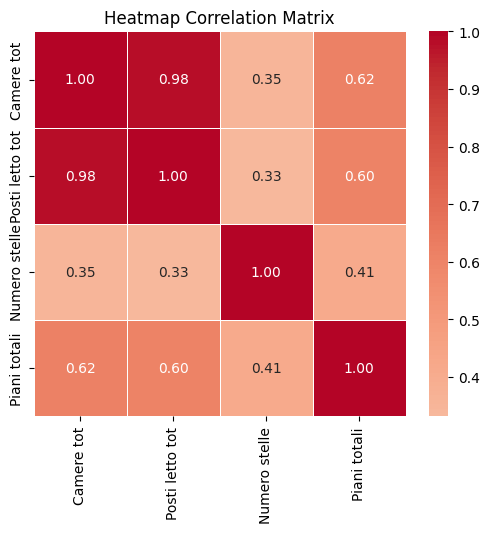

In [58]:
plt.figure(figsize=(6, 5))

sns.heatmap(
    matrice_correlazione,
    annot=True,        
    fmt=".2f",          
    cmap='coolwarm',    
    center=0,           
    linewidths=.5,      
    cbar=True          
)

plt.title('Heatmap Correlation Matrix')
plt.show()

In [59]:
data[data['Piani totali'].isna()]
#we can use machine learning to infer the value

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
244,ACCA PALACE,RESIDENCE,4,VIA,NICOTERA GIOVANNI,9,1508,9,41,<NA>,82
412,ALBERGO ACCURSIO,ALBERGO,3,VLE,CERTOSA,88,7174,8,27,<NA>,39
191,ALBERGO LARIO,ALBERGO,1,VIA,LARIO,40,1171,9,7,<NA>,17
429,ALBERGO LOMBARDIA,ALBERGO,3,VLE,LOMBARDIA,74,2400,3,96,<NA>,157
339,ALBERGO MARTE,ALBERGO,2,VIA,SFORZA ASCANIO,81,5201,5,15,<NA>,25
...,...,...,...,...,...,...,...,...,...,...,...
185,UNKNOWN,RESIDENCE,2,VIA,IPPODROMO,8,6492,8,116,<NA>,232
248,UNKNOWN,ALBERGO,4,VIA,ORSEOLO PIETRO,1,5113,6,59,<NA>,101
326,UNKNOWN,ALBERGO,4,VIA,SAN TOMASO,8,723,1,11,<NA>,22
355,UNKNOWN,ALBERGO,4,VIA,STEPHENSON GIORGIO,55,0,0,256,<NA>,512


In [ ]:
feature="Piani totali"
data["Old_piani_tot"]=data["Piani totali"]
parameters = list(set(["Camere tot", "Posti letto tot", "Numero stelle"]))

#Create a Linear Regression model to estimate the missing data
model = linear_model.LinearRegression()
model.fit(X = data[parameters].loc[data[feature].notnull()], y = data[feature].loc[data[feature].notnull()])
model_predicted = model.predict(data[parameters].loc[data[feature].isnull()])

rounded_predictions = np.round(model_predicted)
print(feature + " successfully inputed")
data.loc[data[feature].isnull(), feature] = rounded_predictions

Piani totali successfully imputed


In [61]:
y_train_pred = model.predict(data[parameters].loc[data[feature].notnull()])
rounded_predictions = np.round(y_train_pred)
conf_matrix_train = confusion_matrix(data[feature].loc[data[feature].notnull()], rounded_predictions)

print(conf_matrix_train)

[[ 0  0 15  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  5 10  6  0  1  0  0  0  0  0  0  0  0]
 [ 0  0 92 15  7  1  0  0  0  0  0  0  0  0]
 [ 0  0 10 76  7  3  1  0  0  0  0  0  0  0]
 [ 0  0  0  9 56  6  3  0  0  0  0  0  0  0]
 [ 0  0  1  3 15 24  1  0  0  0  1  1  0  0]
 [ 0  0  0  1 10  9 12  1  0  0  1  0  0  0]
 [ 0  0  0  0  4  3  2  6  1  2  0  0  0  0]
 [ 0  0  0  0  3  1  1  1  8  0  0  0  0  0]
 [ 0  0  0  1  0  1  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  1  0  0  1  0  0  0  0]]


In [62]:
data["Piani totali"].unique()

<IntegerArray>
[5, 4, 2, 3, 6, 7, 1, 11, 8, 10, 9, 12, 17, 13]
Length: 14, dtype: Int64

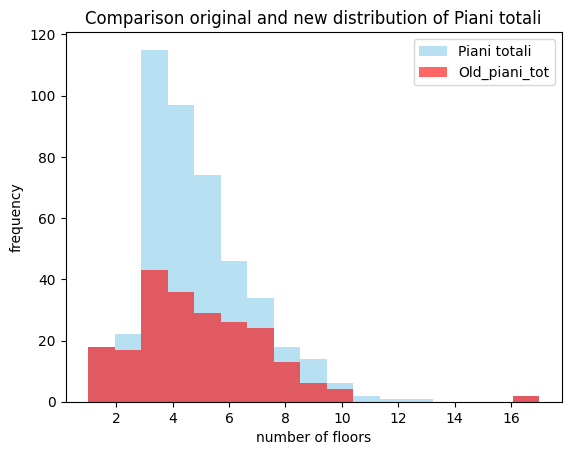

In [63]:
data[["Piani totali","Old_piani_tot"]].plot.hist(
    bins=17,            # Numero di intervalli
    alpha=0.6,          # Trasparenza (cruciale per vedere entrambe le distribuzioni)
    color=["skyblue","red"],
    title='Comparison original and new distribution of Piani totali'
)

plt.xlabel('number of floors')
plt.ylabel('frequency')
plt.show()

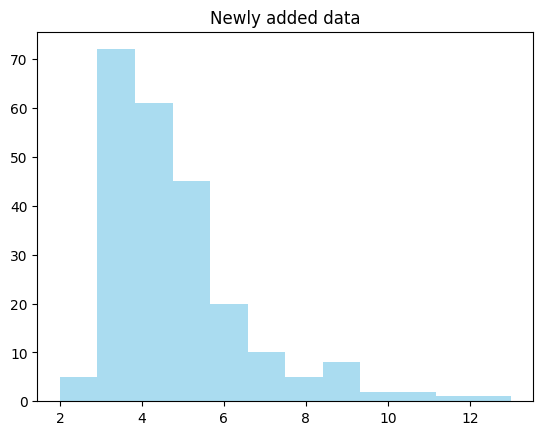

In [64]:
plt.hist(np.round(model_predicted), bins=12, color='skyblue', alpha=0.7)
plt.title('Newly added data')
plt.show()

In [65]:
data = data.drop(["Old_piani_tot"], axis = 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 450 entries, 244 to 388
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Nome             450 non-null    object
 1   Tipologia        450 non-null    object
 2   Numero stelle    450 non-null    Int64 
 3   Tipo via         450 non-null    object
 4   Nome via         450 non-null    object
 5   Civico           450 non-null    Int64 
 6   Codice via       450 non-null    Int64 
 7   Municipio        450 non-null    Int64 
 8   Camere tot       450 non-null    Int64 
 9   Piani totali     450 non-null    Int64 
 10  Posti letto tot  450 non-null    Int64 
dtypes: Int64(7), object(4)
memory usage: 45.3+ KB


## Outlier detection

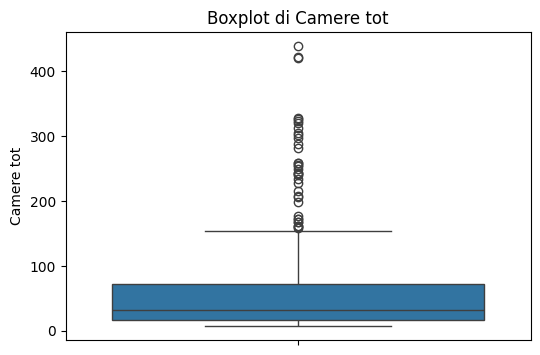

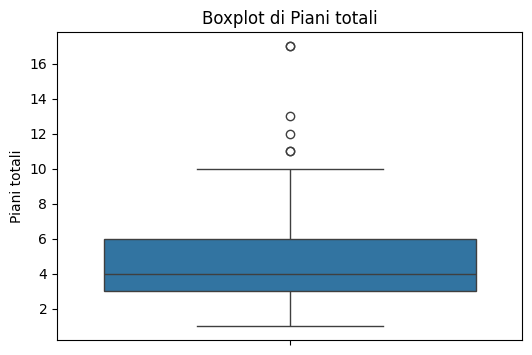

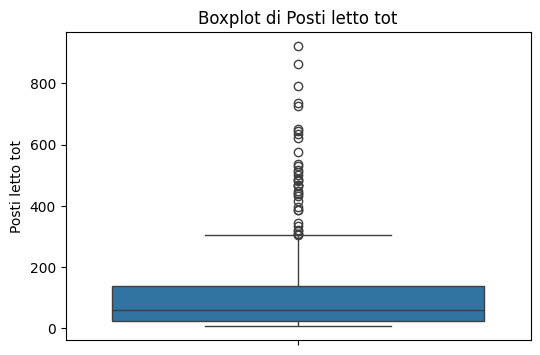

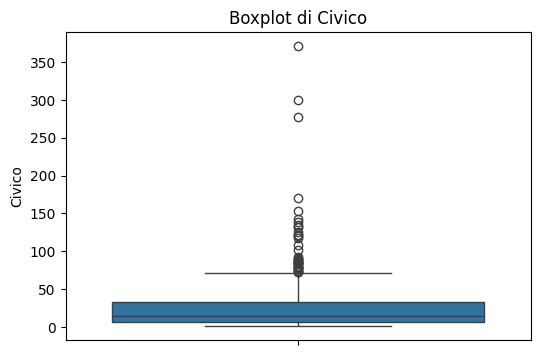

In [68]:
# BoxPlot:
%matplotlib inline

num_cols = ['Camere tot', 'Piani totali', 'Posti letto tot','Civico']

for c in num_cols:
    plt.figure(figsize=(6,4))          
    sns.boxplot(y=data[c])        
    plt.title(f"Boxplot di {c}")
    plt.show()

## Data deduplication

In [70]:
# Find candidate pair
indexer = recordlinkage.Index()

indexer.full()
candidate_links = indexer.index(data)

print(len(data), len(candidate_links))
candidate_links

450 101025


MultiIndex([(412, 244),
            (353, 244),
            (353, 412),
            (104, 244),
            (104, 412),
            (104, 353),
            (  4, 244),
            (  4, 412),
            (  4, 353),
            (  4, 104),
            ...
            (388,  61),
            (388, 166),
            (388,   9),
            (388,  62),
            (388,  87),
            (388, 148),
            (388, 185),
            (388, 248),
            (388, 326),
            (388, 355)],
           length=101025)

In [71]:
#COMPARE THE RECORDS

compare_cl = recordlinkage.Compare()
#Define the way in which the tuples should be compared specifying the list of attributes

#Here we compare attributes based on a similarity measure
compare_cl.string('Nome', 'Nome', method='jarowinkler', threshold=0.9, label='Nome')
compare_cl.string('Nome via', 'Nome via', method='jarowinkler', threshold=0.9, label='Via')

# these two attributes have to match exactly
compare_cl.exact('Codice via', 'Codice via', label='Codice via')

features = compare_cl.compute(candidate_links, data)
features

Nome  Via  Codice via
412 244   0.0  0.0           0
353 244   0.0  0.0           0
    412   0.0  0.0           0
104 244   0.0  0.0           0
    412   0.0  0.0           0
...       ...  ...         ...
388 148   1.0  0.0           0
    185   1.0  0.0           0
    248   1.0  0.0           0
    326   1.0  0.0           0
    355   1.0  0.0           0

[101025 rows x 3 columns]

In [72]:
#The last step is to decide which records belong to the same hotel.
features.sum(axis=1).value_counts().sort_index(ascending=False)

##Compare the matches
matches = features[features.sum(axis=1) > 2]

print("Number of matches:", len(matches))

#define matches with reset index, to be used to get the original records
idx_level0 = matches.index.get_level_values(0)
idx_level1 = matches.index.get_level_values(1)

matches

Number of matches: 9


,,Nome,Via,Codice via
277,276,1.0,1.0,1
422,423,1.0,1.0,1
302,301,1.0,1.0,1
377,373,1.0,1.0,1
106,109,1.0,1.0,1
328,330,1.0,1.0,1
7,8,1.0,1.0,1
47,48,1.0,1.0,1
211,208,1.0,1.0,1


In [78]:
# Get indexes interleaving the values (to have duplicates closer)
idx = pd.Index(list(itertools.chain.from_iterable(zip(idx_level0, idx_level1))))
duplicates = data.loc[idx]
duplicates

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
277,AMBROSIANA,ALBERGO,1,VIA,PLINIO CAIO SECONDO,22,2144,3,16,3,22
276,AMBROSIANA,ALBERGO,1,VIA,PLINIO CAIO SECONDO,22,2144,3,14,3,22
422,GREEN HOUSE RESIDENCE,RESIDENCE,4,VLE,FAMAGOSTA,48,5353,6,54,3,97
423,GREEN HOUSE,ALBERGO,3,VLE,FAMAGOSTA,50,5353,6,45,4,92
302,HOTEL ADLER,ALBERGO,3,VIA,RICORDI GIOVANNI,10,2251,3,23,5,43
301,HOTEL ADLER,ALBERGO,-1,VIA,RICORDI GIOVANNI,10,2251,3,23,2,47
377,HOTEL BERNINA,ALBERGO,3,VIA,TORRIANI NAPO,27,2126,2,44,4,75
373,HOTEL BERNA,ALBERGO,4,VIA,TORRIANI NAPO,18,2126,2,122,6,197
106,HOTEL BRIANZA,ALBERGO,3,VIA,CASTALDI PANFILO,16,2119,3,25,2,36
109,HOTEL BAVIERA,ALBERGO,4,VIA,CASTALDI PANFILO,7,2119,2,52,4,92


In [79]:
#We keep the one with the highest number of rooms/bedrooms
idx_to_remove = duplicates.groupby(['Codice via'])['Camere tot'].idxmin()

data_clean = data.drop(idx_to_remove)
data_clean


,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
244,ACCA PALACE,RESIDENCE,4,VIA,NICOTERA GIOVANNI,9,1508,9,41,5,82
412,ALBERGO ACCURSIO,ALBERGO,3,VLE,CERTOSA,88,7174,8,27,4,39
353,ALBERGO DEL SOLE,ALBERGO,1,VIA,SPONTINI GASPARE,6,2141,3,17,2,40
104,ALBERGO FELICE CASATI,ALBERGO,4,VIA,CASATI FELICE,18,2122,3,99,3,145
4,ALBERGO FENICE,ALBERGO,3,CSO,BUENOS AIRES,2,2129,3,46,4,98
...,...,...,...,...,...,...,...,...,...,...,...
185,UNKNOWN,RESIDENCE,2,VIA,IPPODROMO,8,6492,8,116,5,232
248,UNKNOWN,ALBERGO,4,VIA,ORSEOLO PIETRO,1,5113,6,59,5,101
326,UNKNOWN,ALBERGO,4,VIA,SAN TOMASO,8,723,1,11,4,22
355,UNKNOWN,ALBERGO,4,VIA,STEPHENSON GIORGIO,55,0,0,256,9,512


In [80]:
#Saving the clean dataset to a csv file
data_clean.to_csv("Comune_di_Milano_clean_dataset.csv", encoding="utf-8", index=False)

# Report on clean dataset

In [2]:
data_clean = pd.read_csv('Comune_di_Milano_clean_dataset.csv')
data_clean.head()

,Nome,Tipologia,Numero stelle,Tipo via,Nome via,Civico,Codice via,Municipio,Camere tot,Piani totali,Posti letto tot
0,ACCA PALACE,RESIDENCE,4,VIA,NICOTERA GIOVANNI,9,1508,9,41,5,82
1,ALBERGO ACCURSIO,ALBERGO,3,VLE,CERTOSA,88,7174,8,27,4,39
2,ALBERGO DEL SOLE,ALBERGO,1,VIA,SPONTINI GASPARE,6,2141,3,17,2,40
3,ALBERGO FELICE CASATI,ALBERGO,4,VIA,CASATI FELICE,18,2122,3,99,3,145
4,ALBERGO FENICE,ALBERGO,3,CSO,BUENOS AIRES,2,2129,3,46,4,98


In [3]:
# Generate report
profile_clean = ProfileReport(data_clean, title="Pandas Profiling Report")
profile_clean

# Save profile into html file
profile_clean.to_file("STRUTTURE_Clean_Dataset_Report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:00<00:00, 161885.42it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]